<a href="https://colab.research.google.com/github/evk2103/prediction_of_car_prices/blob/main/EDA_cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подержанные автомобили

Датасет содержит информацию о характеристиках и ценах подержанных автомобилей в некоторой стране

## Импорт библиотек, константы

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
RANDOM_STATE = 42

In [3]:
# DATASET_PATH = "https://raw.githubusercontent.com/evgpat/edu_stepik_from_idea_to_mvp/main/datasets/cars.csv"
DATASET_PATH = 'https://raw.githubusercontent.com/evk2103/prediction_of_car_prices/main/cars.csv'

## Загрузка и обзор данных

### Загрузка

In [4]:
# загрузка данных
df = pd.read_csv(DATASET_PATH)

### Описание данных

**Целевая переменная**
- `selling_price`: цена продажи, числовая

**Признаки**
- `name` (string): модель автомобиля
- `year` (numeric, int): год выпуска с завода-изготовителя
- `km_driven` (numeric, int): пробег на дату продажи
- `fuel` (categorical: _Diesel_ или _Petrol_, или _CNG_, или _LPG_, или _electric_): тип топлива
- `seller_type` (categorical: _Individual_ или _Dealer_, или _Trustmark Dealer_): продавец
- `transmission` (categorical: _Manual_ или _Automatic_): тип трансмиссии
- `owner` (categorical: _First Owner_ или _Second Owner_, или _Third Owner_, или _Fourth & Above Owner_): какой по счёту хозяин?
- `mileage` (string, по смыслу числовой): пробег, требует предобработки
- `engine` (string, по смыслу числовой): рабочий объем двигателя, требует предобработки
- `max_power` (string, по смыслу числовой): пиковая мощность двигателя, требует предобработки
- `torque` (string, по смыслу числовой, а то и 2): крутящий момент, требует предобработки
- `seats` (numeric, float; по смыслу categorical, int)

In [5]:
# информация от столбцах
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6999 non-null   object 
 1   year           6999 non-null   int64  
 2   selling_price  6999 non-null   int64  
 3   km_driven      6999 non-null   int64  
 4   fuel           6999 non-null   object 
 5   seller_type    6999 non-null   object 
 6   transmission   6999 non-null   object 
 7   owner          6999 non-null   object 
 8   mileage        6797 non-null   object 
 9   engine         6797 non-null   object 
 10  max_power      6803 non-null   object 
 11  torque         6796 non-null   object 
 12  seats          6797 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 711.0+ KB


In [6]:
# случайные три записи из датасета
df.sample(3)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
4728,Maruti Baleno Delta Diesel,2016,635000,52000,Diesel,Dealer,Manual,First Owner,27.39 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
2192,Chevrolet Optra Magnum 2.0 LT,2012,400000,64000,Diesel,Individual,Manual,First Owner,16.52 kmpl,1991 CC,123.7 bhp,305Nm@ 2000rpm,5.0
4759,Renault Pulse RxL Optional,2013,290000,90000,Diesel,Individual,Manual,First Owner,23.08 kmpl,1461 CC,63.12 bhp,160Nm@ 2000rpm,5.0


In [8]:
# удалим строки с пропусками
df = df.dropna()

In [9]:
df['mileage'] = df['mileage'].apply(lambda x: x.split()[0])
df['mileage'] = df['mileage'].astype('float')

In [10]:
df['engine'] = df['engine'].apply(lambda x: x.split()[0])
df['engine'] = df['engine'].astype('int')

In [11]:
df['max_power'] = df['max_power'].apply(lambda x: x.split()[0])
df['max_power'] = df['max_power'].astype('float')

In [12]:
df['seats'] = df['seats'].astype('int8')

In [13]:
def extract_torque(string):
  string = string.lower()
  num = float(re.findall(r'\d+\.*\d*', string.split()[0])[0])
  if 'kgm' in string:
    num = round(num * 9.8068, 2)
  return num

In [14]:
def extract_revolutions(string):
  string = string.lower().replace(',', '')
  nums = re.findall(r'\d{4}', string)
  if nums:
    nums = list(map(int, nums))
    if len(nums) > 1:
      num = round(sum(nums)/2)
    else:
      num = nums[0]
  else:
    num = 0
  return num

In [15]:
df['torque_1'] = df['torque'].apply(extract_torque)
df['torque_2'] = df['torque'].apply(extract_revolutions)

In [16]:
default_torque_2 = round(df[(df['torque_1']==400) & (df['torque_2']!=0)]['torque_2'].mean())
default_torque_2

2162

In [17]:
df.loc[df['torque_2'] == 0, 'torque_2'] = default_torque_2

In [18]:
df = df.drop(columns=['torque'])

In [19]:
df.describe()

,year,selling_price,km_driven,mileage,engine,max_power,seats,torque_1,torque_2
count,6796.000000,6.796000e+03,6.796000e+03,6796.000000,6796.000000,6796.000000,6796.000000,6796.000000,6796.000000
mean,2014.009859,6.517417e+05,6.896421e+04,19.427859,1458.424662,91.580806,5.418629,181.322669,2882.592554
std,3.858962,8.167471e+05,5.806295e+04,4.044667,501.156353,35.734052,0.965330,118.167138,968.403671
min,1994.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,32.800000,2.000000,47.070000,1300.000000
25%,2012.000000,2.700000e+05,3.333075e+04,16.800000,1197.000000,68.050000,5.000000,111.800000,2000.000000
50%,2015.000000,4.500000e+05,6.000000e+04,19.300000,1248.000000,82.000000,5.000000,170.000000,2400.000000
75%,2017.000000,6.907500e+05,9.500000e+04,22.320000,1582.000000,102.000000,5.000000,209.000000,4000.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,14.000000,3726.580000,5000.000000


<Axes: >

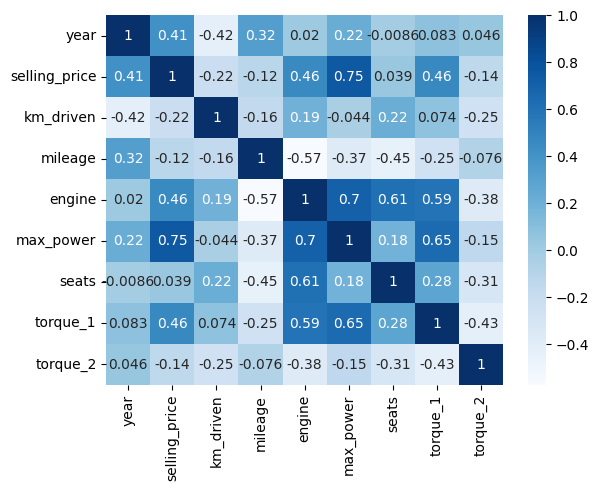

In [20]:
# посмотрим на корреляцию числовых признаков

cols = df.columns[df.dtypes != 'object']

corr = df[cols].corr()
sns.heatmap(corr, cmap="Blues", annot=True)

В числовых признаках нет сильно коррелирующих признаков. С целевой переменной меньше всего коррелирует признак с количеством мест в автомобиле, в дальнейшем на обученых моделях посмотрим насколько важен этот признак. На данном этапе для обучения модели следует оставить все числовые признаки

year


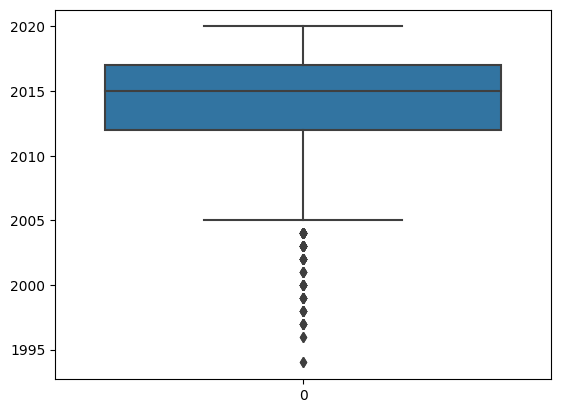

selling_price


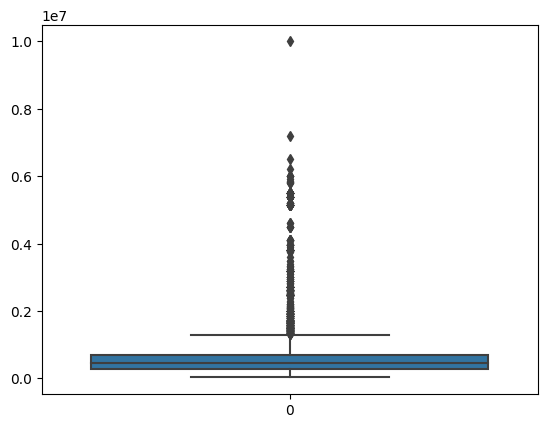

km_driven


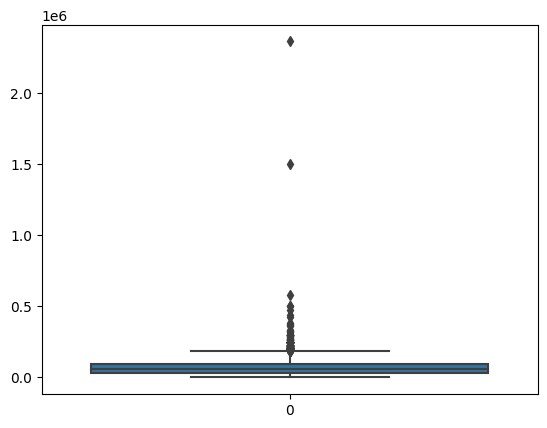

mileage


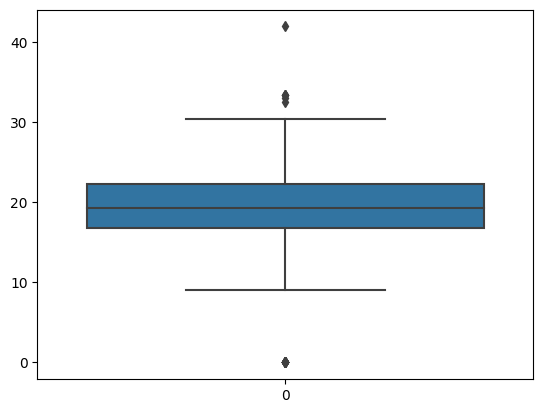

engine


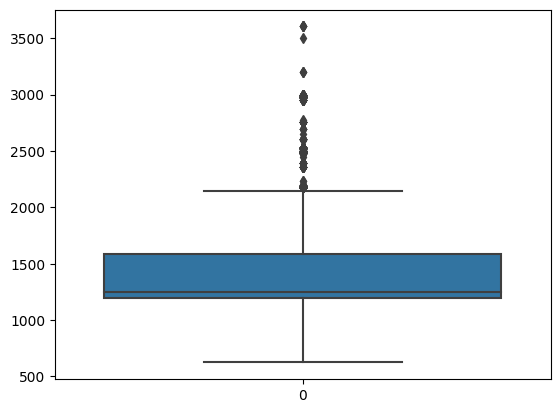

max_power


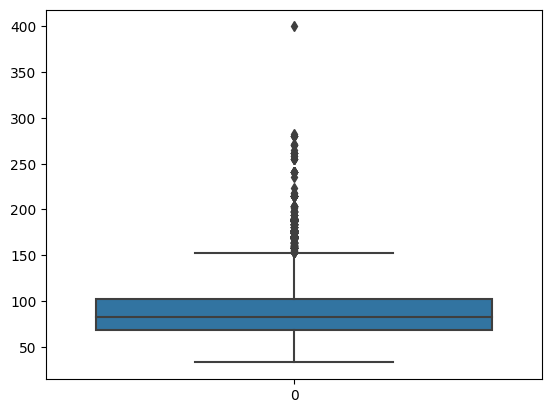

seats


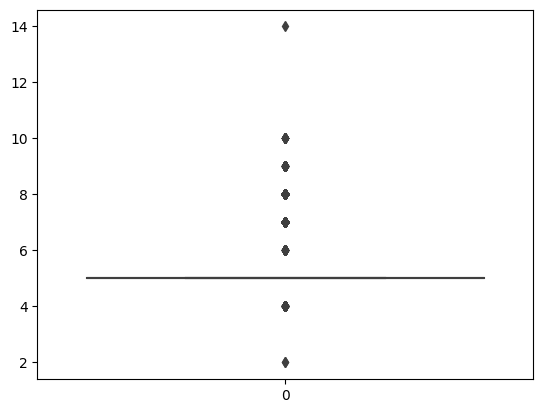

torque_1


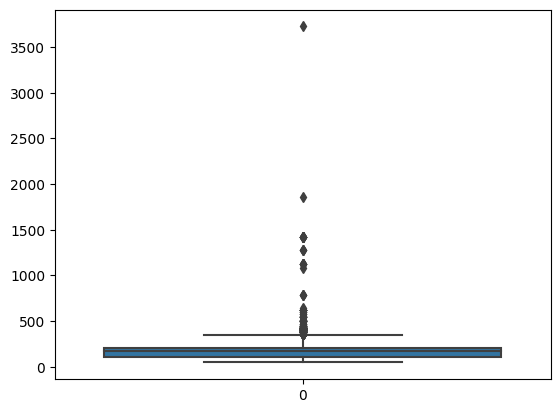

torque_2


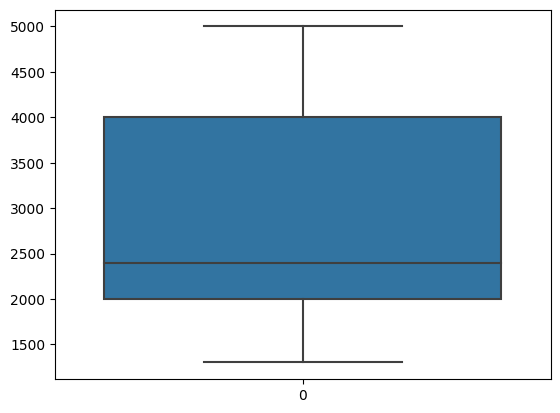

In [21]:
# посмотрим есть ли выбросы в числовых признаках
for col in cols:
    print(col)
    sns.boxplot(df[col])
    plt.show()

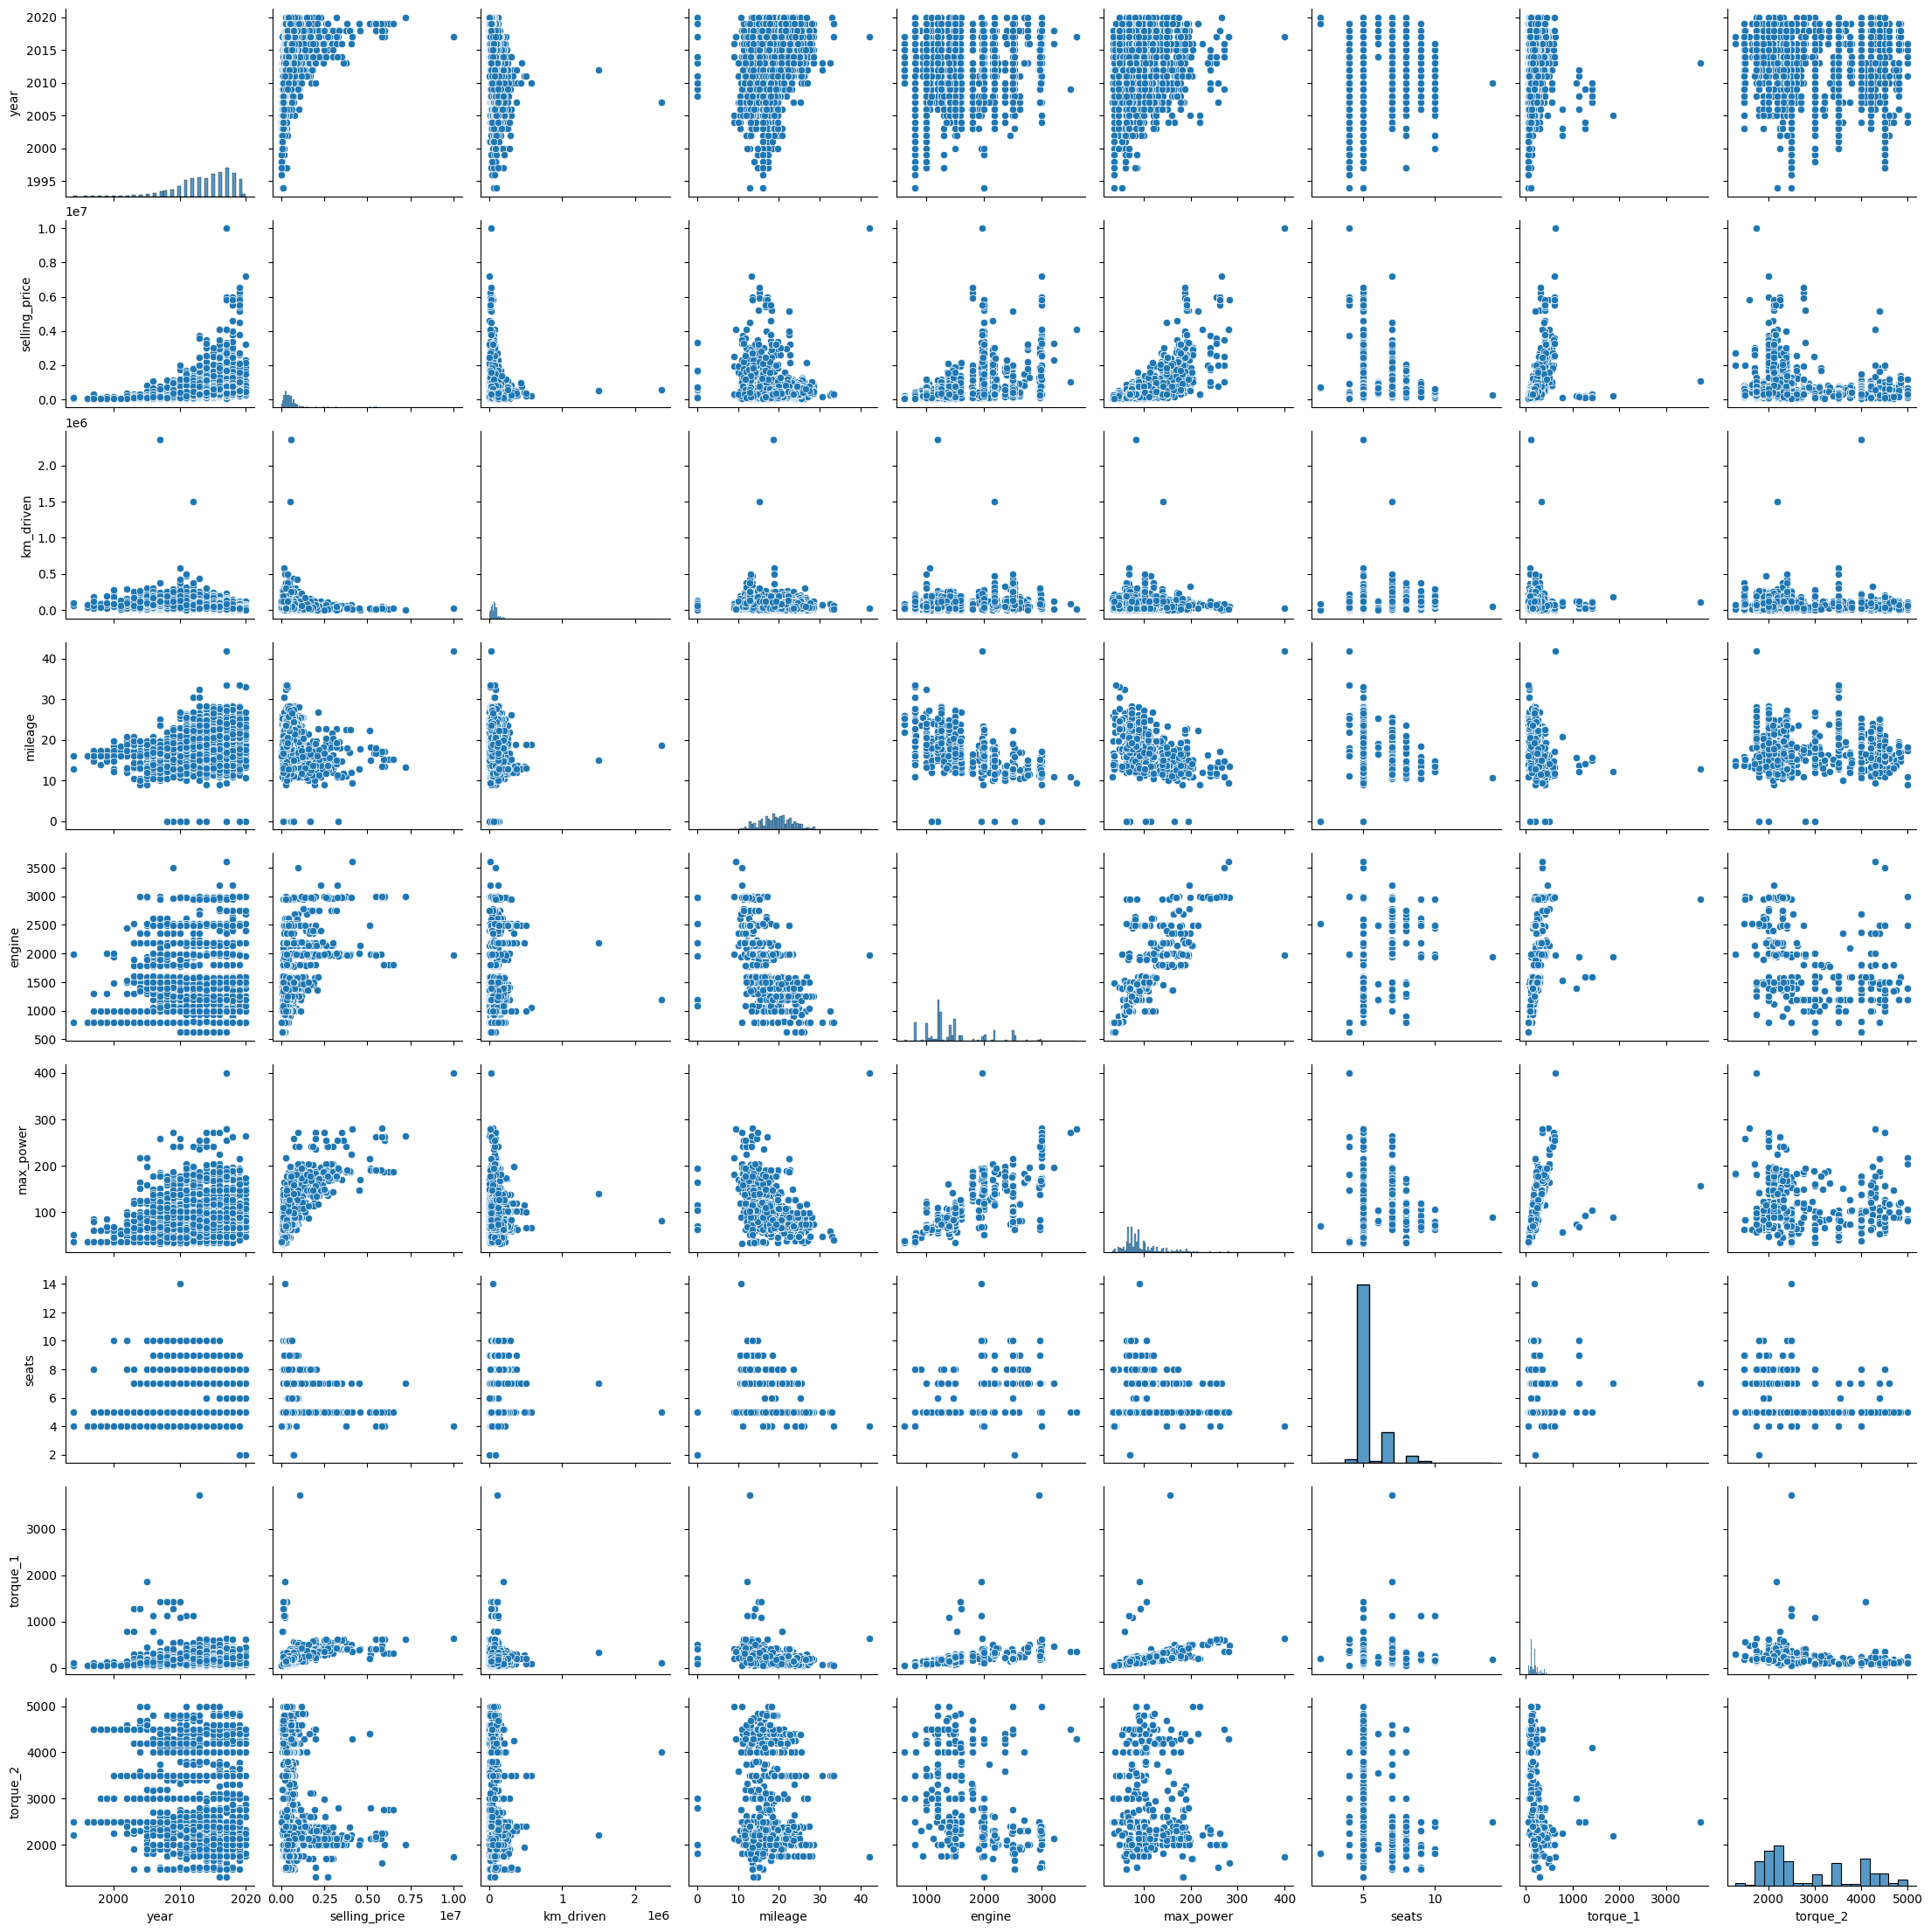

In [22]:
# посмотрим на графики рассеяния числовых признаков и целевой переменной
sns.pairplot(df);

In [23]:
# в целевой переменной selling_price есть точка сильно отдаленная от общей массы. Посмотрим на нее
df[df['selling_price'] > 0.9e+7]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque_1,torque_2
151,Volvo XC90 T8 Excellence BSIV,2017,10000000,30000,Petrol,Individual,Automatic,First Owner,42.0,1969,400.0,4,640.0,1740


In [24]:
# эта строка выделяеся не только по стоимости авто, но и по параметру max_power сильно превосходит другие
# удалим эту строку
df.drop(index=[151], inplace=True)

In [25]:
# во всех графиках рассеяния параметра torque_1 (крутящий момент) выделяется облако точек со значением параметра выше 750. Вероятно, в данных была указана неправильная единица изменения
# посмотрим сколько объектов в этом облаке
df[df['torque_1'] > 750].shape

(24, 14)

In [26]:
# удали эти строки
df = df[df['torque_1'] <= 750]

In [27]:
# на графике ящик с усами параметра km_driven видны несколько сильно отдаленных объекта. посмотрим на них
df[df['km_driven'] > 1.0e+06]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque_1,torque_2
1551,Mahindra XUV500 W6 2WD,2012,500000,1500000,Diesel,Individual,Manual,First Owner,15.1,2179,140.00,7,330.0,2200
3003,Hyundai i20 Asta 1.2,2007,550000,2360457,Petrol,Individual,Manual,Second Owner,18.6,1197,81.83,5,114.7,4000


огромный пробег данных автомобилей в сочетании с ценой близкой к средной по всей выборке вызывает подозрения. Удалим эти 2 строки из выборки

In [28]:
df.drop(index=[1551, 3003], inplace=True)

Теперь посмотрим на категориальные признаки

In [29]:
df.describe(include='object')

,name,fuel,seller_type,transmission,owner
count,6769,6769,6769,6769,6769
unique,1838,4,3,2,5
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner
freq,116,3684,5613,5875,4505


в калонках fuel, seller_type, transmission небольшое количество уникальных значений, поэтому для этих колонок можно применить one-hot-encoding.
Для колонки owner будем использовать label-encoding.
Для оставшихся категориальных признаков попробуем разные способы кодирования.

In [30]:
!pip install association-metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for association-metrics: filename=association_metrics-0.0.1-py3-none-any.whl size=3930 sha256=edb4815185c5174b6f23f1db7be1ef60d770b6b1906503f803ee4eb33597034a
  Stored in directory: /root/.cache/pip/wheels/01/47/5f/4360ef6988df6f1b0c1857cab43334269110160bd97b716936
Successfully built association-metrics


In [31]:
import association_metrics as am

XC = df.apply(lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)
cramersv.fit()

,name,fuel,seller_type,transmission,owner
name,1.000000,1.000000,0.864517,1.000000,0.720696
fuel,1.000000,1.000000,0.111621,0.053958,0.039788
seller_type,0.864517,0.111621,1.000000,0.377217,0.169164
transmission,1.000000,0.053958,0.377217,1.000000,0.171652
owner,0.720696,0.039788,0.169164,0.171652,1.000000


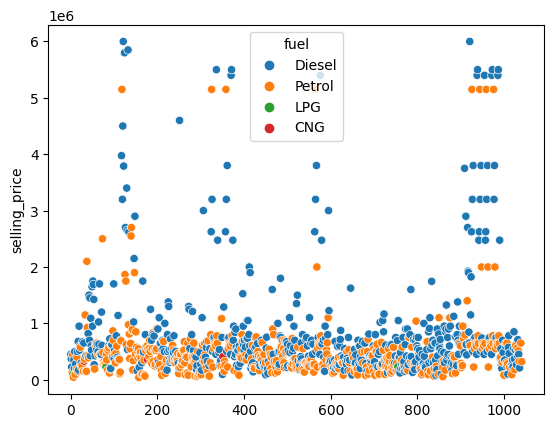

In [32]:
sns.scatterplot(data=df.iloc[:1000], x=df.iloc[:1000].index, y=df['selling_price'][:1000], hue='fuel');

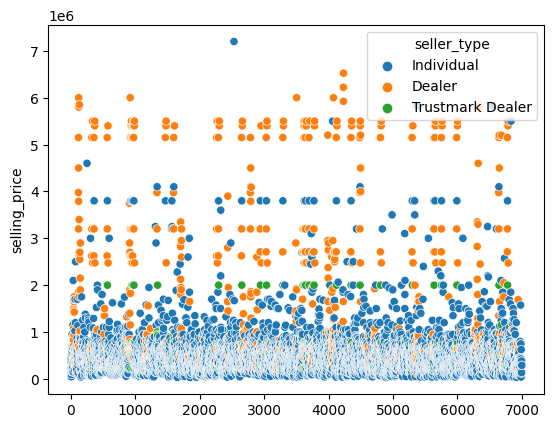

In [33]:
sns.scatterplot(data=df, x=df.index, y=df['selling_price'], hue='seller_type');

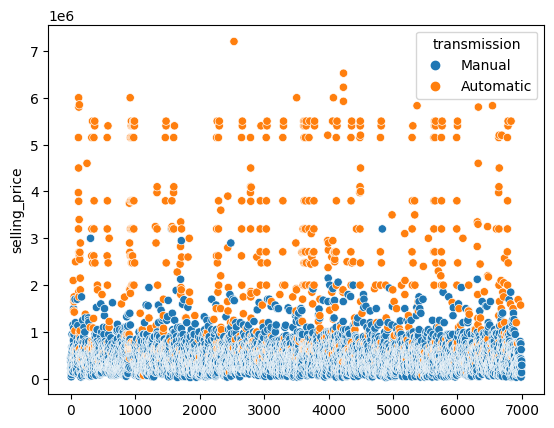

In [34]:
sns.scatterplot(data=df, x=df.index, y=df['selling_price'], hue='transmission');

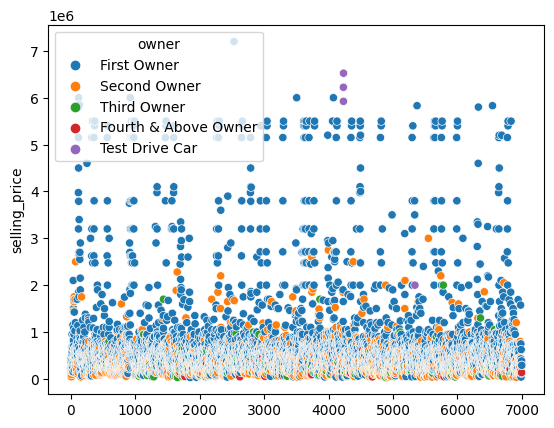

In [35]:
sns.scatterplot(data=df, x=df.index, y=df['selling_price'], hue='owner');

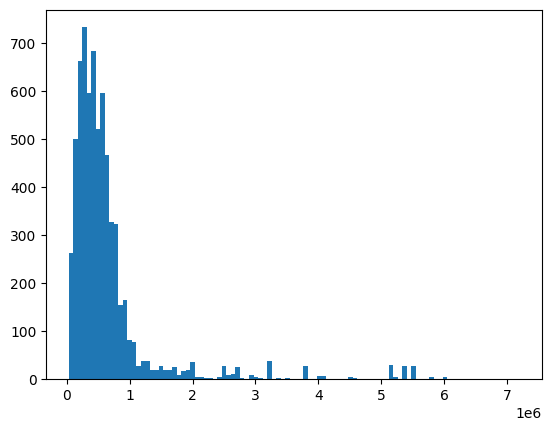

In [36]:
# посмотрим на распределение целевой переменной
plt.hist(df.selling_price, bins=100);

Распределение целевой переменной не является нормальным. Для обучения линейных моделей целевую переменную следует пролагорифмировать.

Сохраним очищенный датасет в отдельный файл

In [39]:
df.to_csv('./clean_cars.csv', index=False)